In [3]:
import tensorflow as tf
import keras as keras

In [4]:
print("tensorflow:", tf.__version__)
print("keras:", keras.__version__)

tensorflow: 2.13.0
keras: 2.13.1


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [46]:
pip install pandas

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---------------- ----------------------- 4.7/11.5 MB 23.7 MB/s eta 0:00:01
   ---------------------------------- ----- 10.0/11.5 MB 24.8 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 24.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 3.4 Classifying movie reviews: a binary classification example

In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.

### 3.4.1 The IMDB dataset
* a set of 50,000 highly polarized reviews from the Internet Movie Database.
* They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.
* The IMDB dataset comes packaged with Keras.
* It has already been preprocessed:
  - the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

In [5]:
# Loading the IMDB dataset (~ 80 MB of data)
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
# only keep the top 10,000 most frequently occurring words in the training data; Rare words will be discarded.
# train_data and test_data are lists of reviews where each review is a list of word indices (encoding a sequence of words).
# train_labels and test_labels are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive

In [6]:
print(train_data[24999]) # print any from 0 to 24999
print(train_data.shape)
print(train_labels[24999])
print(train_labels.shape)

[1, 17, 6, 194, 337, 7, 4, 204, 22, 45, 254, 8, 106, 14, 123, 4, 2, 270, 2, 5, 2, 2, 732, 2098, 101, 405, 39, 14, 1034, 4, 1310, 9, 115, 50, 305, 12, 47, 4, 168, 5, 235, 7, 38, 111, 699, 102, 7, 4, 4039, 9245, 9, 24, 6, 78, 1099, 17, 2345, 2, 21, 27, 9685, 6139, 5, 2, 1603, 92, 1183, 4, 1310, 7, 4, 204, 42, 97, 90, 35, 221, 109, 29, 127, 27, 118, 8, 97, 12, 157, 21, 6789, 2, 9, 6, 66, 78, 1099, 4, 631, 1191, 5, 2642, 272, 191, 1070, 6, 7585, 8, 2197, 2, 2, 544, 5, 383, 1271, 848, 1468, 2, 497, 2, 8, 1597, 8778, 2, 21, 60, 27, 239, 9, 43, 8368, 209, 405, 10, 10, 12, 764, 40, 4, 248, 20, 12, 16, 5, 174, 1791, 72, 7, 51, 6, 1739, 22, 4, 204, 131, 9]
(25000,)
0
(25000,)


### 3.4.2 Preparing the data
You can’t feed lists of integers into a neural network. You have to turn your lists into tensors (multi-dimensional numerical arrays).

In [7]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # Creates an all-zero matrix of shape
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # Set specific indices of results[i] to 1s
    return results

* Example to use `vectorize_squences` function

In [8]:
# Example sequences (each sequence is a list of word indices)
sequences = [
    [1, 3, 5],    # first sequence
    [0, 2, 3],    # second sequence
    [2, 4]        # third sequence
]

# Vectorizing the example sequences
vectorized_data = vectorize_sequences(sequences, dimension=6)  # Using 6 as the dimension (small for example purposes)

print(vectorized_data)

[[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0.]]


In [9]:
# Vectorize training and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print(x_train[24999])
print(x_train.shape)

# also vectorize your labels (convert into a NumPy array)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
print(y_train[24999])
print(y_test[24999])

[0. 1. 1. ... 0. 0. 0.]
(25000, 10000)
0.0
0.0


### 3.4.3 Building your network
The input data is vectors, and the labels are scalars (1s and 0s): this is the easiest setup
you’ll ever encounter. A type of network that performs well on such a problem is
a simple stack of fully connected (Dense) layers with relu activations: Dense(16, activation='relu').
The argument being passed to each Dense layer (16) is the number of hidden units of the layer.
Each such Dense layer with a relu activation implements the following chain of tensor operations:
*    output = relu(dot(W, input) + b)
Having 16 hidden units means the weight matrix W will have shape (input_dimension, 16): 
the dot product with W will project the input data onto a 16-dimensional representation space 
(and then you’ll add the bias vector b and apply the relu operation).
Having more hidden units (a higher-dimensional representation space) allows your network to learn more-complex representations, 
but it makes the network more computationally expensive and may lead to learning unwanted patterns 
(patterns that will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such a stack of Dense layers:
* How many layers to use
* How many hidden units to choose for each layer

For now, we will assume that
* Two intermediate layers with 16 hidden units each
* A third layer that will output the scalar prediction regarding the sentiment of the current review

The intermediate layers will use relu as their activation function, and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target “1”: how likely the review is to be positive).

The three-layer network is
* input -> Dense (units = 16) -> Dense (Units = 16) -> Dense (Units = 1) -> Output

In [10]:
# Keras model implementation
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Finally, you need to choose a loss function and an optimizer. Because you’re facing a
binary classification problem and the output of your network is a probability (you end
your network with a single-unit layer with a sigmoid activation), it’s best to use the *binary_crossentropy* loss.
crossentropy is usually the best choice when you’re dealing with models that output probabilities.
Crossentropy is a quantity from the field of Information Theory that measures the distance between probability distributions or, in this
case, between the ground-truth distribution and your predictions.

In [11]:
# Compiling the model by configuring the optimizer
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 3.4.4 Validating your approach

* Create a validation set by setting apart 10,000 samples from the original training data.

In [12]:
# Setting aside a validation data
x_val = x_train[:10000] #  takes the first 10,000 rows from x_train
print(x_train.shape)
print(x_val.shape)

partial_x_train = x_train[10000:]
print(partial_x_train.shape)

y_val = y_train[:10000]
partial_y_train = y_train[10000:]
print(y_val.shape)
print(partial_y_train.shape)

(25000, 10000)
(10000, 10000)
(15000, 10000)
(10000,)
(15000,)


* train the model for 20 epochs (20 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples. At the same time, monitor loss and accuracy on the 10,000 samples that you set apart. You do so by passing the validation data as the validation_data argument.

In [13]:
# Training the model
#model.compile(optimizer='rmsprop',
#              loss='binary_crossentropy',
#              metrics=['acc'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512, # batch size can be chosen for any power of 2
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 34ms/step - loss: 0.5262 - accuracy: 0.7745 - val_loss: 0.4026 - val_accuracy: 0.8502
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3223 - accuracy: 0.8947 - val_loss: 0.3392 - val_accuracy: 0.8618
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2421 - accuracy: 0.9195 - val_loss: 0.3079 - val_accuracy: 0.8762
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1972 - accuracy: 0.9329 - val_loss: 0.2746 - val_accuracy: 0.8902
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1620 - accuracy: 0.9494 - val_loss: 0.2854 - val_accuracy: 0.8855
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1422 - accuracy: 0.9532 - val_loss: 0.2833 - val_accuracy: 0.8853
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1186 - accuracy: 0.9635 - val_loss: 0.3006 - val_accuracy: 0.8830
Epoch 8/20
30/30 [=

In [14]:
# Let's make a dictionary containing data about everything that happened during training
history_dict = history.history
history_dict.keys()
# The dictionary contains four entries: one per metric that was being monitored during training and during validation.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


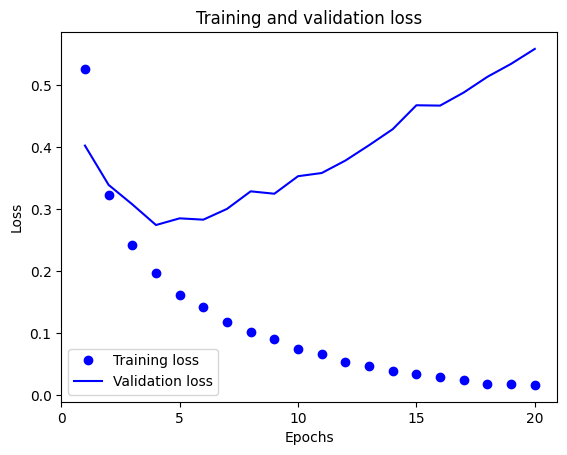

In [17]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') # 'bo' means blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # 'b' means solid blue line

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Setting the x-ticks to integers and adding breaks at every 5 epochs
plt.xticks(range(0, len(loss_values) + 1, 5))  # Adjust the step size to 5

plt.show()

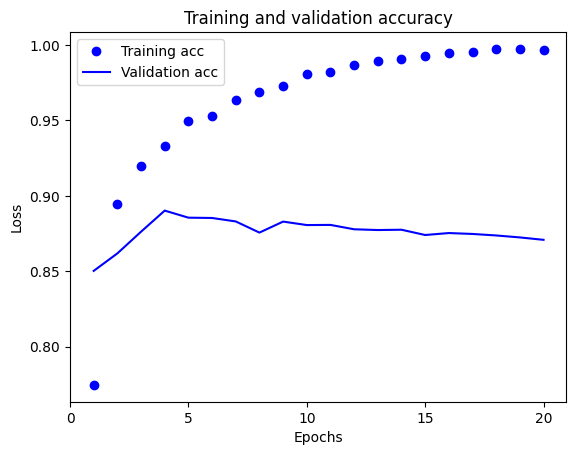

In [18]:
# Plotting the training and validation accuracy
plt.clf() # clear the figure

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Setting the x-ticks to integers and adding breaks at every 5 epochs
plt.xticks(range(0, len(loss_values) + 1, 5))  # Adjust the step size to 5

plt.show()

* It seems there is an overfitting problem.  To prevent overfitting, you could stop training after 5 epochs

In [22]:
# Retraining a model from scratch
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=8, batch_size=512) # batch size can be chosen for any power of 2

results = model.evaluate(x_test, y_test)

print(results)

Epoch 1/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7373 - loss: 0.5461
Epoch 2/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9051 - loss: 0.2796
Epoch 3/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9208 - loss: 0.2181
Epoch 4/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9392 - loss: 0.1757
Epoch 5/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9451 - loss: 0.1558
Epoch 6/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9544 - loss: 0.1356
Epoch 7/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9611 - loss: 0.1179
Epoch 8/8
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9655 - loss: 0.1045
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8676 - loss: 0.3715
[0.3706571161746979, 0.8676000237464905]


## 3.5 Classifying newswires: a multiclass classification example

* Build a network to classify Reuters newswires into 46 mutually exclusive topics.
* Because each data point should be classified into only one category, the problem is an instance of single-label, multiclass classification.

### 3.5.1 The Reuters dataset
* consists of a set of short newswires and their topics, published by Reuters in 1986.
* It’s a simple, widely used toy dataset for text classification.
* There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.
* It comes packaged as part of Keras.

In [52]:
# Loading the Reuters dataset
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
# the argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.

print(train_data.shape) # 8,982 training examples
print(train_labels.shape)

print(test_data.shape) # 2,246 test examples
print(test_labels.shape)

(8982,)
(8982,)
(2246,)
(2246,)


In [53]:
print(train_data[10]) # each example is a list of integers (word indices)
print(len(train_data[10])) # each train_data example has a different length

print(train_labels[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]
31
3


In [54]:
# Encoding the data (The same function as before)
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # Creates an all-zero matrix of shape
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # Set specific indices of results[i] to 1s
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
print(x_train.shape)
print(x_test.shape)

(8982, 10000)
(2246, 10000)


In [55]:
v_train_labels = vectorize_sequences(train_labels)
v_test_labels = vectorize_sequences(test_labels)

# alternative way to vertorization
from keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(train_labels)

print(train_labels.shape)
print(v_train_labels.shape)

(8982,)
(8982, 10000)


### 3.5.3 Building the network

* Since we have 46 different classes, we need to increase the number of neurons in hidden layers. Let's go with 64 units

In [56]:
# model definition
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) # output layer has 46 units for 46 different classes

In [57]:
# Compiling the model
model.compile(optimizer='rmsprop', # rmsprop can adjust the learning rate for each parameter individually, 
              # but SGD has a fixed learning rate that can have slow convergence
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.5.4 Validating your approach

* Let’s set apart 1,000 samples in the training data to use as a validation set.

In [58]:
# For labels, as similar as before
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension)) # Creates an all-zero matrix of shape
    for i, label in enumerate(labels):
        results[i, label] = 1. # Set specific indices of results[i] to 1s
    return results

one_hot_train_labels = to_one_hot(train_labels) # vectorize training labels
one_hot_test_labels = to_one_hot(test_labels)

print(train_labels.shape)
print(one_hot_train_labels.shape)

print(test_labels.shape)
print(one_hot_test_labels.shape)

(8982,)
(8982, 46)
(2246,)
(2246, 46)


In [59]:
####  If you are using a built-in way to do this in Keras (Easier)
from keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print(train_labels.shape)
print(one_hot_train_labels.shape)

print(test_labels.shape)
print(one_hot_test_labels.shape)

(8982,)
(8982, 46)
(2246,)
(2246, 46)


In [60]:
# Let’s set apart 1,000 samples in the training data to use as a validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [61]:
# Now, let’s train the network for 20 epochs
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4151 - loss: 3.1202 - val_accuracy: 0.6060 - val_loss: 1.7928
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6495 - loss: 1.6413 - val_accuracy: 0.6860 - val_loss: 1.4023
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7265 - loss: 1.2450 - val_accuracy: 0.7050 - val_loss: 1.2353
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7739 - loss: 1.0222 - val_accuracy: 0.7550 - val_loss: 1.1143
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8160 - loss: 0.8571 - val_accuracy: 0.7730 - val_loss: 1.0354
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8467 - loss: 0.6985 - val_accuracy: 0.7890 - val_loss: 0.9680
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8651 - loss: 0.6178 - val_accuracy: 0.8000 - val_loss: 0.9328
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9037 - loss: 0.4879 - val_accuracy: 0.7880 - val_loss

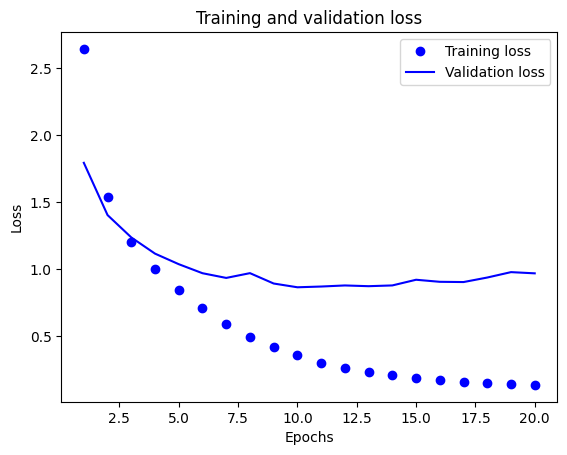

In [64]:
# let’s display its loss and accuracy curves
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Setting the x-ticks to integers and adding breaks at every 5 epochs
# plt.xticks(range(0, len(loss_values) + 1, 5))  # Adjust the step size to 5

plt.show()

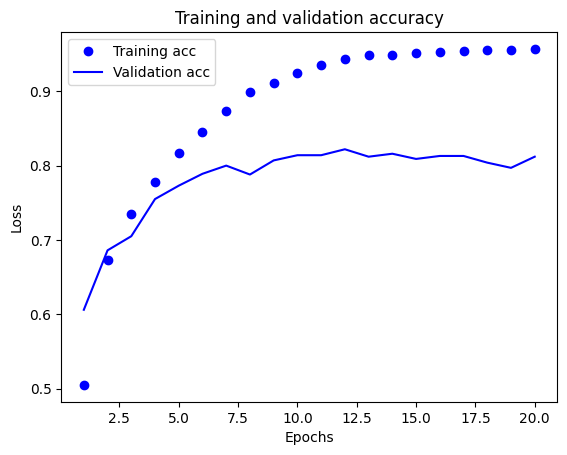

In [65]:
# Plotting the training and validation accuracy
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Setting the x-ticks to integers and adding breaks at every 5 epochs
# plt.xticks(range(0, len(loss_values) + 1, 5))  # Adjust the step size to 5

plt.show()

* The network begins to overfit after 10 epochs. Let’s train a new network from 
scratch for10e epochs and then evaluate it on the test set
.

In [66]:
# Retraining a model from scratch
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=10,
          batch_size=512,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3481 - loss: 3.3068 - val_accuracy: 0.6070 - val_loss: 1.9325
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6477 - loss: 1.7081 - val_accuracy: 0.6880 - val_loss: 1.4035
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7234 - loss: 1.2432 - val_accuracy: 0.7090 - val_loss: 1.2495
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7732 - loss: 1.0396 - val_accuracy: 0.7450 - val_loss: 1.1255
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8131 - loss: 0.8484 - val_accuracy: 0.7710 - val_loss: 1.0603
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8428 - loss: 0.7272 - val_accuracy: 0.7780 - val_loss: 1.0090
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8625 - loss: 0.6181 - val_accuracy: 0.8020 - val_loss: 0.9615
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8910 - loss: 0.5214 - val_accuracy: 0.7960 - val_loss

### 3.5.5 Generating predictions on new data


In [70]:
# Generating predictions for new data
predictions = model.predict(x_test)

print(predictions[0].shape) # Each entry in predictions is a vector of length 46:

print("predicted: ", np.argmax(predictions[15])) # The largest entry is the predicted class—the class with the highest probability

print("True:", test_labels[15])

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(46,)
predicted:  11
True: 11


### 3.5.6 Exercises
* Let's download the cement data and read it into a pandas dataframe.

In [104]:
!pip install pandas

   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ------------- -------------------------- 3.7/10.8 MB 24.2 MB/s eta 0:00:01
   ---------------------------------- ----- 9.2/10.8 MB 21.9 MB/s eta 0:00:01
   ---------------------------------------- 10.8/10.8 MB 21.7 MB/s eta 0:00:00


In [71]:
import pandas as pd
import numpy as np

concrete_data = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0101EN/labs/data/concrete_data.csv')
concrete_data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


* So the first concrete sample has 540 cubic meter of cement, 0 cubic meter of blast furnace slag, 0 cubic meter of fly ash, 162 cubic meter of water, 2.5 cubic meter of superplaticizer, 1040 cubic meter of coarse aggregate, 676 cubic meter of fine aggregate. Such a concrete mix which is 28 days old, has a compressive strength of 79.99 MPa

In [39]:
# Let's check how many data points we have.
concrete_data.shape

(1030, 9)

So, there are approximately 1000 samples to train our model on

In [42]:
# Let's check the dataset for any missing values. (Descriptive Statistics)
concrete_data.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [43]:
concrete_data.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [44]:
# Split data into predictors and target
# The target variable in this problem is the concrete sample strength.
concrete_data_columns = concrete_data.columns
print(concrete_data_columns)

predictors = concrete_data[concrete_data_columns[concrete_data_columns != 'Strength']] # all columns but Strength
print(predictors.shape)
target = concrete_data['Strength'] # Strength column
print(target.shape)

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Strength'],
      dtype='object')
(1030, 8)
(1030,)


In [45]:
predictors.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [46]:
target.head()

0    79.99
1    61.89
2    40.27
3    41.05
4    44.30
Name: Strength, dtype: float64

Finally, the last step is to normalize the data by substracting the mean and dividing by the standard deviation.


In [47]:
predictors_norm = (predictors - predictors.mean()) / predictors.std()
predictors_norm.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,2.476712,-0.856472,-0.846733,-0.916319,-0.620147,0.862735,-1.217079,-0.279597
1,2.476712,-0.856472,-0.846733,-0.916319,-0.620147,1.055651,-1.217079,-0.279597
2,0.491187,0.795140,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,3.551340
3,0.491187,0.795140,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,5.055221
4,-0.790075,0.678079,-0.846733,0.488555,-1.038638,0.070492,0.647569,4.976069


Let's save the number of predictors to *n_cols* since we will need this number when building our network.


In [49]:
print(predictors_norm.shape)
n_cols = predictors_norm.shape[1] # number of predictors, which is 8

(1030, 8)


In [50]:
# Build a NN
from keras.models import Sequential
from keras.layers import Dense

# define regression model
def regression_model():
    # create model: two hidden layers, each of 50 hidden units
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(n_cols,))) 
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Train and Test the Network


In [51]:
# build the model
model = regression_model()

Next, we will train and test the model at the same time using the *fit* method. We will leave out 30% of the data for validation and we will train the model for 100 epochs.


In [55]:
# fit the model
# Convert predictors and target to NumPy arrays
predictors_norm_np = predictors_norm.to_numpy()  # or predictors_norm.values
target_np = target.to_numpy()  # or target.values

print(predictors_norm.shape)
print(target.shape)

print(predictors_norm_np.shape)
print(target_np.shape)


(1030, 8)
(1030,)
(1030, 8)
(1030,)


In [60]:
# Fit the model with NumPy arrays
model.fit(predictors_norm_np, target_np, validation_split=0.3, epochs=100, verbose=2)
# model.fit(predictors_norm, target, validation_split=0.3, epochs=100, verbose=2)

Epoch 1/100
23/23 - 0s - loss: 30.8066 - val_loss: 129.8282 - 192ms/epoch - 8ms/step
Epoch 2/100
23/23 - 0s - loss: 30.7507 - val_loss: 127.7918 - 28ms/epoch - 1ms/step
Epoch 3/100
23/23 - 0s - loss: 30.1077 - val_loss: 124.5288 - 28ms/epoch - 1ms/step
Epoch 4/100
23/23 - 0s - loss: 29.7928 - val_loss: 133.6788 - 25ms/epoch - 1ms/step
Epoch 5/100
23/23 - 0s - loss: 29.9797 - val_loss: 126.4677 - 25ms/epoch - 1ms/step
Epoch 6/100
23/23 - 0s - loss: 29.0811 - val_loss: 130.4576 - 24ms/epoch - 1ms/step
Epoch 7/100
23/23 - 0s - loss: 28.9513 - val_loss: 125.8301 - 24ms/epoch - 1ms/step
Epoch 8/100
23/23 - 0s - loss: 28.8167 - val_loss: 128.1515 - 26ms/epoch - 1ms/step
Epoch 9/100
23/23 - 0s - loss: 28.9695 - val_loss: 132.0172 - 25ms/epoch - 1ms/step
Epoch 10/100
23/23 - 0s - loss: 29.1238 - val_loss: 125.4032 - 24ms/epoch - 1ms/step
Epoch 11/100
23/23 - 0s - loss: 29.1322 - val_loss: 119.0451 - 26ms/epoch - 1ms/step
Epoch 12/100
23/23 - 0s - loss: 28.2263 - val_loss: 124.1451 - 24ms/epoch

# 3.6 Predicting house prices: a regression example

### 3.6.1 The Boston Housing Price dataset

* predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on.
* It has relatively few data points: only 506, split between 404 training samples and 102 test samples.

In [61]:
# Loading the Boston housing dataset
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [62]:
print(train_data.shape)
print(test_data.shape)


(404, 13)
(102, 13)


In [63]:
train_data_df = pd.DataFrame(train_data)
train_data_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


### 3.6.2 Preparing the data


* It would be problematic to feed into a neural network values that all take wildly different ranges.
  - do feature-wise normalization

In [64]:
# Normalizing the data
mean = train_data.mean(axis=0) 
# the parameter axis=0 is used to specify that the mean should be calculated column-wise (across the rows for each column) when normalizing the data. 
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# Note that the quantities used for normalizing the test data are computed using the training data. 
# You should never use in your workflow any quantity computed on the test data.
test_data -= mean
test_data /= std

### 3.6.3 Building your network

Because so few samples are available, you’ll use a very small network with two hidden
layers, each with 64 units.

In [74]:
from keras import models
from keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mean_absolute_error']) # Mean absolute error
    return model

### 3.6.4 Validating your approach using K-fold validation



In [75]:
k = 3 # 3-fold CV
print(len(train_data)) # 404
num_val_samples = len(train_data) // k # integer division (134.6667 -> rounds down to 134)
print(num_val_samples)
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    # When axis=0, the function concatenates arrays vertically (i.e., by stacking rows one after the other). 
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model() # already defined in the above cell #128
    model.fit(partial_train_data, partial_train_targets,
                        epochs=num_epochs, batch_size=1, verbose=0)
    # verbose=0 means that no output will be printed during the training process
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

404
134
processing fold # 0
processing fold # 1
processing fold # 2


In [76]:
print(all_scores)
print(np.mean(all_scores)) 
np.std(all_scores)

[2.5093343257904053, 2.8559300899505615, 2.5673611164093018]
2.6442085107167563


0.15157241930800977

##### * In this case, you’re off by abo64 $2,700 on average;  Let’s try training the network a bit longer: 500 epochs
* To keep a record of how 
well the model does at each epoch, you’ll modify the training loop to save the perepoc 
validation score log.

In [88]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    # When axis=0, the function concatenates arrays vertically (i.e., by stacking rows one after the other). 
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model() # already defined in the above cell #128
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    # verbose=0 means that no output will be printed during the training process
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2


In [89]:
# compute the average of the per-epoch MAE scores for all folds.
    # When axis=0, the function concatenates arrays vertically (i.e., by stacking rows one after the other). 
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

* [x[i] for x in all_mae_histories]:
  - iterates through the list all_mae_histories (which presumably contains the MAE values for each fold from k-fold cross-validation)
  - For each x (which represents a list of MAE values for a fold), it accesses the value at index i (which corresponds to the MAE for the i-th epoch).
  - This creates a list of MAE values for the i-th epoch across all folds.

* np.mean([...]):
  - After collecting all the MAE values for the i-th epoch from the folds, np.mean() calculates the average of those values.
  - This gives the average MAE for the i-th epoch across all folds in the k-fold cross-validation process.

* for i in range(num_epochs):
  - iterates over all epochs
  - For each epoch, it calculates the average MAE from the different validation folds.
 
* Example: Assume that k = 3 and 4 epochs
  - Assume that the MAE values for each fold across 4 epochs are given as follows:
  - Fold 1:
    - Epoch 1: .5; Epoch 2: .4; Epoch 3: .35; Epoch 4: .3
  - Fold 2:
    - Epoch 1: .55; Epoch 2: .45; Epoch 3: .4; Epoch 4: .35
  - Fold 3:
    - Epoch 1: .6; Epoch 2: .5; Epoch 3: .45; Epoch 4: .4
   
  - Now we can calculate the mean MAE for each epoch i.

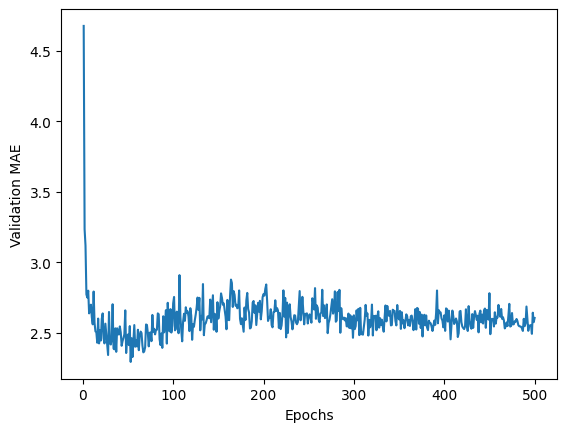

In [94]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance.
Let’s do the followin:
* Omit the first 10 data points, which are on a different scale than the rest of the curve.
* Replace each point with an exponential moving average of the previous points, 
to obtain a smooth curve.g

In [95]:
def smooth_curve(points, factor=0.9): # points: a list or array of data points that you want to smooth
    # factor: smoothing factor to the previous smoothed value
    smoothed_points = [] # initialization
    for point in points: # iterates over each point in the points list.
        if smoothed_points: # checks whether smoothed_points already contains any values.
            # if it does
            previous = smoothed_points[-1] # retrieves the last smoothed value
            smoothed_points.append(previous * factor + point * (1 - factor)) # 90% weight to the previous value
        else: # If not (i.e., the list is empty), it simply appends the first point.
            smoothed_points.append(point)
    return smoothed_points

In [96]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

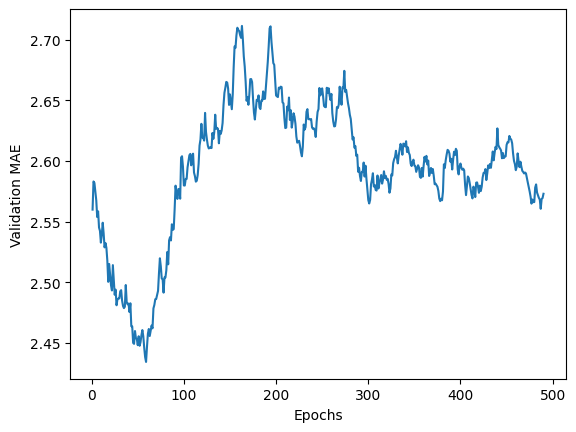

In [97]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs. Past that point, you start overfitting.

In [98]:
# Training the final model
model = build_model()

model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

4/4 [==============================] - 0s 1ms/step - loss: 18.0206 - mean_absolute_error: 2.6586
2.6585853099823


You’re still off by about $2660.

### 4.4.2 Adding weight regularizaiton

To demonstrate how to add regularization to a Feedforward Neural Network (FNN) using a real dataset, let's use the Diabetes dataset from `sklearn.datasets` to demonstrate how to apply Elastic Net regularization to a Feedforward Neural Network (FNN).

In [152]:
from sklearn.datasets import load_diabetes

# Load the diabetes dataset
data = load_diabetes()

print(data.keys()) # to inspect the Bunch object data using keys()

X = data.data
y = data.target

print(X.shape)
print(y.shape)

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])
(442, 10)
(442,)


In [108]:
# Split into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # random_state can be considered as random seed

In [109]:
# Normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We'll apply Elastic Net regularization using the `l1_l2` regularizer, which allows us to combine L1 and L2 penalties.

    * L1 (Lasso) regularization encourages sparsity (many weights become zero)
    * L2 (Ridge) regularization reduces the magnitude of all weights.

In [112]:
from tensorflow.keras.regularizers import l1_l2

def build_model_with_elastic_net():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                     kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),  # Elastic Net regularization
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        layers.Dense(1, activation='linear')  # Output layer for regression (predicting a continuous target)
    ])
    
    model.compile(optimizer='adam',
                  loss='mean_squared_error',  # Regression loss
                  metrics=['mean_absolute_error'])
    return model

# Build the model
model = build_model_with_elastic_net()

* The values 0.001 for both L1 and L2 regularization are small, indicating a mild regularization effect. These values are often used as starting points when experimenting with regularization because:

    * They provide a balance between model complexity and regularization.
      
    * They allow the model to train without being too constrained (over-regularized) but still prevent overfitting by penalizing large weights and unnecessary complexity.

      
* These values (0.001) are chosen as a default or starting point. In practice, you may want to experiment with different regularization strengths (e.g., 0.01, 0.1, etc.) to find the best values for your dataset. A larger value would apply a stronger regularization effect, potentially improving performance for models prone to overfitting.
ty.

In [113]:
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/50
9/9 - 0s - loss: 31401.8965 - mean_absolute_error: 158.2782 - val_loss: 22281.8926 - val_mean_absolute_error: 133.3577 - 384ms/epoch - 43ms/step
Epoch 2/50
9/9 - 0s - loss: 31144.4961 - mean_absolute_error: 157.4892 - val_loss: 22068.2949 - val_mean_absolute_error: 132.5879 - 22ms/epoch - 2ms/step
Epoch 3/50
9/9 - 0s - loss: 30838.7480 - mean_absolute_error: 156.5593 - val_loss: 21807.4785 - val_mean_absolute_error: 131.6435 - 23ms/epoch - 3ms/step
Epoch 4/50
9/9 - 0s - loss: 30442.9043 - mean_absolute_error: 155.3629 - val_loss: 21463.9746 - val_mean_absolute_error: 130.4016 - 20ms/epoch - 2ms/step
Epoch 5/50
9/9 - 0s - loss: 29918.6348 - mean_absolute_error: 153.7458 - val_loss: 21007.1523 - val_mean_absolute_error: 128.7611 - 22ms/epoch - 2ms/step
Epoch 6/50
9/9 - 0s - loss: 29198.2656 - mean_absolute_error: 151.5744 - val_loss: 20412.3340 - val_mean_absolute_error: 126.6229 - 21ms/epoch - 2ms/step
Epoch 7/50
9/9 - 0s - loss: 28226.6270 - mean_absolute_error: 148.6840 - v

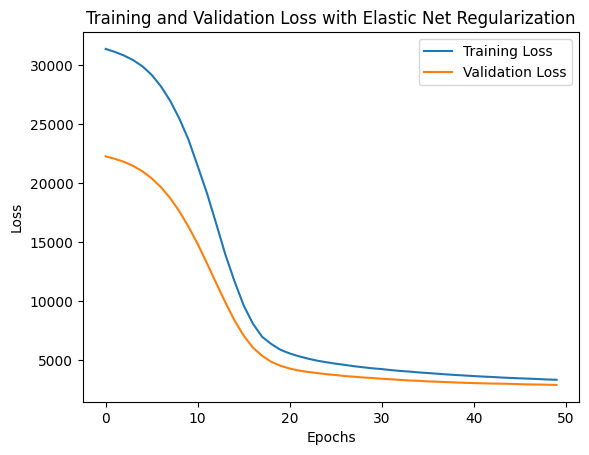

In [114]:
# Visualize Training and Validation Loss
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss with Elastic Net Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [115]:
# Evaluate the Model on Test Data
test_loss, test_mae = model.evaluate(X_test, y_test)
print('Test Mean Absolute Error:', test_mae)

3/3 [==============================] - 0s 1ms/step - loss: 3393.4097 - mean_absolute_error: 46.9249
Test Mean Absolute Error: 46.9249267578125


In [116]:
# refit using epochs =30
model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/30
9/9 - 0s - loss: 3279.1060 - mean_absolute_error: 45.3480 - val_loss: 2861.5532 - val_mean_absolute_error: 41.7077 - 33ms/epoch - 4ms/step
Epoch 2/30
9/9 - 0s - loss: 3251.4263 - mean_absolute_error: 45.1856 - val_loss: 2859.7805 - val_mean_absolute_error: 41.7211 - 20ms/epoch - 2ms/step
Epoch 3/30
9/9 - 0s - loss: 3223.6353 - mean_absolute_error: 45.0610 - val_loss: 2850.4182 - val_mean_absolute_error: 41.7219 - 19ms/epoch - 2ms/step
Epoch 4/30
9/9 - 0s - loss: 3204.1145 - mean_absolute_error: 44.9076 - val_loss: 2843.2578 - val_mean_absolute_error: 41.6205 - 21ms/epoch - 2ms/step
Epoch 5/30
9/9 - 0s - loss: 3178.7778 - mean_absolute_error: 44.7977 - val_loss: 2835.0994 - val_mean_absolute_error: 41.6519 - 20ms/epoch - 2ms/step
Epoch 6/30
9/9 - 0s - loss: 3158.7554 - mean_absolute_error: 44.6592 - val_loss: 2828.5432 - val_mean_absolute_error: 41.6330 - 20ms/epoch - 2ms/step
Epoch 7/30
9/9 - 0s - loss: 3138.7793 - mean_absolute_error: 44.5531 - val_loss: 2829.2751 - val_mea

In [117]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print('Test Mean Absolute Error:', test_mae)

3/3 [==============================] - 0s 1ms/step - loss: 2987.8582 - mean_absolute_error: 43.5192
Test Mean Absolute Error: 43.51915740966797


### 4.4.3 Adding dropout

* Dropout is one of the most effective and most commonly used regularization techniques for neural networks.

* Dropout, applied to a layer, consists of randomly dropping out 
(setting to zero) a number of output features of the layer during training.
* The dropout rate is the fraction 
of the features that are zeroed out; it’s usually set between 0.2 and 0.5

* At test time, no 
units are dropped out; instead, the layer’s output values are scaled down by a facto 
equal to the dropout ra.e,.


In [151]:
# Load the Iris dataset
from sklearn.datasets import load_iris

data = load_iris()
X = data.data  # Features
y = data.target  # Target (class labels)

print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [127]:
# One-hot encode the target
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False) # initializes a OneHotEncoder object from the sklearn.preprocessing module.
y = encoder.fit_transform(y.reshape(-1, 1)) 
# This reshapes the target array y from a 1D array into a 2D column vector because OneHotEncoder expects a 2D input. 
# The -1 means that the number of rows will be inferred based on the data length.


* OneHotEncoder: This is a class used to convert categorical labels (in this case, class labels) into a format that can be fed into machine learning models. Specifically, it transforms a single categorical label into a binary vector (one-hot encoded format) where each class is represented by a vector with one 1 and the rest 0.

In [128]:
# Split into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [129]:
# Standardize the data (important for neural networks)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [130]:
# Build a Neural Network with Dropout and Elastic Net Regularization
def build_classification_model_with_regularization():
    model = keras.Sequential([
        # First hidden layer with Elastic Net (L1 + L2) and ReLU activation
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                     kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        # Add Dropout layer with 20% dropout rate
        layers.Dropout(0.3),
        
        # Second hidden layer with Elastic Net (L1 + L2) and ReLU activation
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
        # Add another Dropout layer with 30% dropout rate
        layers.Dropout(0.3),
        
        # Output layer for classification (Softmax activation for multi-class classification)
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # Categorical crossentropy for multi-class classification
                  metrics=['accuracy'])
    return model

# Build the model
model = build_classification_model_with_regularization()

In [131]:
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=16, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/50
6/6 - 0s - loss: 1.6424 - accuracy: 0.4583 - val_loss: 1.5363 - val_accuracy: 0.6667 - 376ms/epoch - 63ms/step
Epoch 2/50
6/6 - 0s - loss: 1.5161 - accuracy: 0.6250 - val_loss: 1.4385 - val_accuracy: 0.8750 - 18ms/epoch - 3ms/step
Epoch 3/50
6/6 - 0s - loss: 1.4524 - accuracy: 0.7083 - val_loss: 1.3446 - val_accuracy: 0.9583 - 18ms/epoch - 3ms/step
Epoch 4/50
6/6 - 0s - loss: 1.3588 - accuracy: 0.7708 - val_loss: 1.2568 - val_accuracy: 0.9167 - 19ms/epoch - 3ms/step
Epoch 5/50
6/6 - 0s - loss: 1.2875 - accuracy: 0.7604 - val_loss: 1.1783 - val_accuracy: 0.8750 - 18ms/epoch - 3ms/step
Epoch 6/50
6/6 - 0s - loss: 1.2051 - accuracy: 0.7396 - val_loss: 1.1085 - val_accuracy: 0.8750 - 17ms/epoch - 3ms/step
Epoch 7/50
6/6 - 0s - loss: 1.1413 - accuracy: 0.7708 - val_loss: 1.0427 - val_accuracy: 0.8750 - 19ms/epoch - 3ms/step
Epoch 8/50
6/6 - 0s - loss: 1.0446 - accuracy: 0.7812 - val_loss: 0.9871 - val_accuracy: 0.8750 - 18ms/epoch - 3ms/step
Epoch 9/50
6/6 - 0s - loss: 1.0158 - a

In [132]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

1/1 [==============================] - 0s 11ms/step - loss: 0.3257 - accuracy: 1.0000
Test Accuracy: 1.0


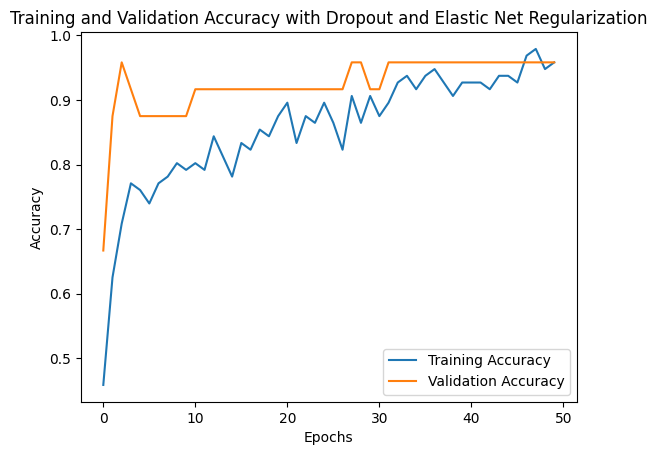

In [133]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy with Dropout and Elastic Net Regularization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [134]:
model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=16, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/20
6/6 - 0s - loss: 0.3656 - accuracy: 0.9688 - val_loss: 0.3706 - val_accuracy: 0.9583 - 30ms/epoch - 5ms/step
Epoch 2/20
6/6 - 0s - loss: 0.3788 - accuracy: 0.9792 - val_loss: 0.3630 - val_accuracy: 0.9583 - 16ms/epoch - 3ms/step
Epoch 3/20
6/6 - 0s - loss: 0.3763 - accuracy: 0.9375 - val_loss: 0.3645 - val_accuracy: 0.9583 - 17ms/epoch - 3ms/step
Epoch 4/20
6/6 - 0s - loss: 0.3786 - accuracy: 0.9479 - val_loss: 0.3614 - val_accuracy: 0.9583 - 17ms/epoch - 3ms/step
Epoch 5/20
6/6 - 0s - loss: 0.3599 - accuracy: 0.9583 - val_loss: 0.3478 - val_accuracy: 0.9583 - 17ms/epoch - 3ms/step
Epoch 6/20
6/6 - 0s - loss: 0.3663 - accuracy: 0.9479 - val_loss: 0.3390 - val_accuracy: 0.9583 - 18ms/epoch - 3ms/step
Epoch 7/20
6/6 - 0s - loss: 0.3516 - accuracy: 0.9479 - val_loss: 0.3334 - val_accuracy: 0.9583 - 19ms/epoch - 3ms/step
Epoch 8/20
6/6 - 0s - loss: 0.3590 - accuracy: 0.9583 - val_loss: 0.3447 - val_accuracy: 0.9583 - 18ms/epoch - 3ms/step
Epoch 9/20
6/6 - 0s - loss: 0.3648 - acc

In [135]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

1/1 [==============================] - 0s 11ms/step - loss: 0.2576 - accuracy: 1.0000
Test Accuracy: 1.0


# FNN for Survival Analysis

* For a survival analysis problem, a Feedforward Neural Network (FNN) can be adapted using methods such as DeepSurv or by incorporating survival-specific loss functions like the Cox Proportional Hazards loss.

* Use the Veterans' Lung Cancer dataset (available in lifelines.datasets) as an example, which contains data on lung cancer patients, their survival times, and associated covariates.

* We will use the Cox Proportional Hazards loss in a neural network framework for survival prediction.

* We'll train the model to predict the hazard function for each individual based on their features.

In [153]:
pip install lifelines tensorflow pandas scikit-learn

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
Note: you may need to restart the kernel to use updated packages.


* In this example, we used the WHAS500 dataset from the sksurv library, which contains heart failure survival data.

* We built a Feedforward Neural Network for survival analysis, using Cox Proportional Hazards loss and evaluated the model using the concordance index.

* The model was trained and evaluated using a custom survival loss function that accounts for censored data.

In [156]:
from sksurv.datasets import load_whas500
import pandas as pd

# Load the WHAS500 dataset
data_x, data_y = load_whas500()

print(data.keys())

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


In [157]:
# Convert to DataFrame for easier manipulation
df_x = pd.DataFrame(data_x)
df_y = pd.DataFrame(data_y)

df_x.head()

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp
0,1,83.0,0,25.54051,0,1,78.0,0,89.0,5.0,1,0,0,152.0
1,0,49.0,0,24.02398,0,1,60.0,0,84.0,5.0,0,1,0,120.0
2,0,70.0,0,22.14290,0,0,88.0,1,83.0,5.0,0,1,0,147.0
3,0,70.0,0,26.63187,1,1,76.0,0,65.0,10.0,0,1,0,123.0
4,0,70.0,0,24.41255,0,1,85.0,0,63.0,6.0,0,1,0,135.0


In [160]:
df_y.head()
print(df_y.columns)

Index(['fstat', 'lenfol'], dtype='object')


In [161]:
# Combine time and event indicator with features
df_y['time'] = df_y['lenfol']
df_y['event'] = df_y['fstat']
df_y = df_y[['time', 'event']]

print(df_x.head())
print(df_y.head())

  afb   age av3       bmi chf cvd  diasbp gender    hr   los miord mitype sho  \
0   1  83.0   0  25.54051   0   1    78.0      0  89.0   5.0     1      0   0   
1   0  49.0   0  24.02398   0   1    60.0      0  84.0   5.0     0      1   0   
2   0  70.0   0  22.14290   0   0    88.0      1  83.0   5.0     0      1   0   
3   0  70.0   0  26.63187   1   1    76.0      0  65.0  10.0     0      1   0   
4   0  70.0   0  24.41255   0   1    85.0      0  63.0   6.0     0      1   0   

   sysbp  
0  152.0  
1  120.0  
2  147.0  
3  123.0  
4  135.0  
     time  event
0  2178.0  False
1  2172.0  False
2  2190.0  False
3   297.0   True
4  2131.0  False


In [162]:
# Preprocess the Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [163]:
# define a simple FNN model for survival analysis using Cox Proportional Hazards loss.
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom Cox Proportional Hazards loss function
# The goal is to calculate the negative partial log-likelihood of the Cox PH model,
def cox_ph_loss(y_true, y_pred):
    time = y_true[:, 0]  # The survival time of the event or censoring
    event = y_true[:, 1]  # Event indicator of whether the event occurred (1) or was censored (0)
    # y_pred: This contains the predicted risk scores for each individual. 
    # These scores represent the model's estimate of the hazard ratio (the higher the score, the higher the estimated risk of the event occurring).

    # Sort the patients by increasing survival time
    order = tf.argsort(time) # gives the indices that would sort the time tensor in ascending order.
    time = tf.gather(time, order) 
    event = tf.gather(event, order)
    y_pred = tf.gather(y_pred, order)
    # reorders the time, event, and y_pred tensors according to the sorted order.
    
    # Calculate the risk score and cumulative risk
    risk = tf.math.exp(y_pred) # risk score
    cum_risk = tf.math.cumsum(risk[::-1])[::-1]  
    # Calculate the cumulative risk in reverse order (over all individuals who have survived up until a certain point in time.)
    log_likelihood = tf.reduce_sum(event * (y_pred - tf.math.log(cum_risk + 1e-9)))

    return -log_likelihood # minimizing negative log-likelihood (same as maximizing log-likelihood)


Example: 

* 
Imagine we have three individuals with risk scores of 2, 3, and 4, and their survival times are 10, 1 and 14 days, respectively:
  - At time 10 (when the first event happens), the sum of all risk scores for individuals who are still at risk (those who have not yet experienced the event) is 2+3+4=9.

  - A    At time 12, only two individuals (the ones with risk scores of 3 and 4) are still at risk, so the cumulative sum of their risk scores is 3

  - 
    At time 14, only the last individual (with a risk score of 4) is still at risk, so the cumulative sum is 4.

In [165]:
# Build the Feedforward Neural Network
def build_survival_model(input_shape):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation=None)  # Output layer with no activation for risk score prediction
    ])
    model.compile(optimizer='adam', loss=cox_ph_loss)
    return model

# Define the input shape and build the model
input_shape = (X_train.shape[1],)
model = build_survival_model(input_shape)

In [167]:
# Prepare the Labels for Training
# prepare the labels by combining the survival times and event indicators into a single array that can be passed to the model
# Prepare the labels for the Cox PH loss function
y_train_prepared = np.vstack([y_train['time'].values, y_train['event'].values]).T
y_test_prepared = np.vstack([y_test['time'].values, y_test['event'].values]).T

In [168]:
## Train the neural network model
history = model.fit(X_train, y_train_prepared, epochs=50, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/50
10/10 - 0s - loss: 1117.9031 - val_loss: 959.9046 - 386ms/epoch - 39ms/step
Epoch 2/50
10/10 - 0s - loss: 1095.1929 - val_loss: 957.3768 - 20ms/epoch - 2ms/step
Epoch 3/50
10/10 - 0s - loss: 1080.2302 - val_loss: 965.0781 - 20ms/epoch - 2ms/step
Epoch 4/50
10/10 - 0s - loss: 1063.6029 - val_loss: 971.7464 - 20ms/epoch - 2ms/step
Epoch 5/50
10/10 - 0s - loss: 1055.7526 - val_loss: 978.1760 - 18ms/epoch - 2ms/step
Epoch 6/50
10/10 - 0s - loss: 1052.8336 - val_loss: 981.3504 - 19ms/epoch - 2ms/step
Epoch 7/50
10/10 - 0s - loss: 1041.9797 - val_loss: 985.8730 - 19ms/epoch - 2ms/step
Epoch 8/50
10/10 - 0s - loss: 1041.5293 - val_loss: 990.4567 - 18ms/epoch - 2ms/step
Epoch 9/50
10/10 - 0s - loss: 1035.5399 - val_loss: 996.8295 - 21ms/epoch - 2ms/step
Epoch 10/50
10/10 - 0s - loss: 1029.1992 - val_loss: 1005.1849 - 18ms/epoch - 2ms/step
Epoch 11/50
10/10 - 0s - loss: 1031.2048 - val_loss: 1005.3765 - 18ms/epoch - 2ms/step
Epoch 12/50
10/10 - 0s - loss: 1029.5530 - val_loss: 1002.3

In [170]:
# Evaluate the model using the concordance index, which measures the predictive acccuracy of survival models
from sksurv.metrics import concordance_index_censored

# Predict risk scores for the test data
risk_scores = model.predict(X_test)

# Calculate the concordance index to evaluate the model's performance
c_index = concordance_index_censored(y_test['event'], y_test['time'], -risk_scores.flatten())
print(f"Concordance Index: {c_index[0]}")


4/4 [==============================] - 0s 1000us/step
Concordance Index: 0.3505572441742654


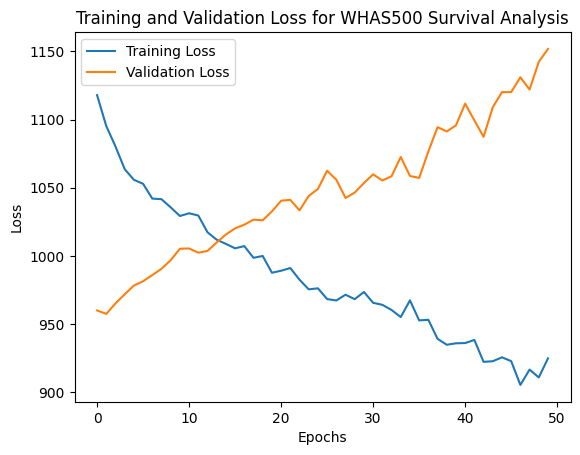

In [171]:
# visualize the training and validation loss
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for WHAS500 Survival Analysis')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [181]:
import pandas as pd
from lifelines.datasets import load_rossi

# Load the Rotterdam Tumor Recurrence dataset
data = load_rossi()

# Show the first few rows of the dataset
print(data.head())


AttributeError: module 'importlib.resources' has no attribute 'files'

# HW #7

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import load_iris
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

# Load the Iris dataset
iris = load_iris()
X = iris.data  # Features (sepal length, sepal width, petal length, petal width)
y = iris.target  # Target labels

In [2]:
# Convert the target to binary (1 for 'setosa', 0 for others)
y_binary = np.where(y == 0, 1, 0)

# Split the dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y_binary, test_size=0.2, random_state=42)


In [3]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(4,)))  # Input layer (4 features)
model.add(Dense(64, activation='relu'))  # Hidden layer 1
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_val, y_val))

Epoch 1/50
12/12 [==============================] - 0s 9ms/step - loss: 0.5680 - accuracy: 0.6667 - val_loss: 0.4649 - val_accuracy: 0.6667
Epoch 2/50
12/12 [==============================] - 0s 2ms/step - loss: 0.4190 - accuracy: 0.7500 - val_loss: 0.3515 - val_accuracy: 0.9000
Epoch 3/50
12/12 [==============================] - 0s 2ms/step - loss: 0.3060 - accuracy: 0.9917 - val_loss: 0.2501 - val_accuracy: 1.0000
Epoch 4/50
12/12 [==============================] - 0s 2ms/step - loss: 0.2093 - accuracy: 1.0000 - val_loss: 0.1645 - val_accuracy: 1.0000
Epoch 5/50
12/12 [==============================] - 0s 2ms/step - loss: 0.1355 - accuracy: 1.0000 - val_loss: 0.1040 - val_accuracy: 1.0000
Epoch 6/50
12/12 [==============================] - 0s 2ms/step - loss: 0.0883 - accuracy: 1.0000 - val_loss: 0.0717 - val_accuracy: 1.0000
Epoch 7/50
12/12 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 1.0000
Epoch 8/50
12/12 [==

1/1 [==============================] - 0s 48ms/step - loss: 8.0264e-04 - accuracy: 1.0000
Validation Accuracy: 100.00%


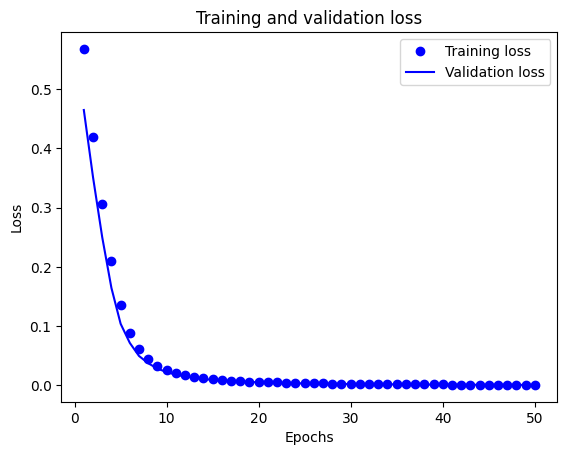

In [5]:
import matplotlib.pyplot as plt

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Plot the training and validation loss over epochs
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')  # 'bo' is for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')  # 'b' is for solid blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()